# Installing libraries

In [ ]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.5/994.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 14.6 MB/s eta 

## 1. Data Loading and Subject Selection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from one.api import ONE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.integrate import odeint
import uuid

# Initialize ONE API
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

# Load datasets tagged with 2021_Q1_IBL_et_al_Behaviour
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# first subject
subject = subjects[0]
print('Selected subject ID: ', subject)

# Load subjectTrials and subjectSessions tables
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Add session metadata ro subject_trials
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

# We only need biasedChoiceWorld sessions
biased_sessions = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld', na=False)].index.unique()
print('Number of biasedChoiceWorld sessions:' ,len(biased_sessions)) #total number of sessions we work on

# Split session into training and testing data
train_sessions, test_sessions = train_test_split(biased_sessions, test_size=0.2, random_state=42) #80% train, 20% test

train_data = subject_trials[subject_trials.index.isin(train_sessions)]
test_data = subject_trials[subject_trials.index.isin(test_sessions)]

print('Training sessions: ',len(train_sessions))
print('Test sessions: ',len(test_sessions))
print('Training trials: ',len(train_data))
print('Test trials: ',len(test_data))

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Selected subject ID:  CSHL045
Number of biasedChoiceWorld sessions: 23
Training sessions:  18
Test sessions:  5
Training trials:  18074
Test trials:  4236


# Feature Enginnering

In [ ]:
def engineer_features(df):
    df = df.copy()
    # Reaction time of mouse
    df['reaction_time'] = df['response_times'] - df['goCue_times']

    # Delay between trials
    df['trial_delay'] = df.groupby('session')['intervals_0'].diff().shift(-1)

    # Performance ~ basically the avg. performance of the mouse in the last 40 trials
    df['performance'] = (
        df.groupby('session')['feedbackType']
        .transform(lambda x: x.rolling(window=40, min_periods=8).mean()))

    # Performance drop ~ here I take the delta between the mean of the performance column of a session and performance in that session
    # Positive value means, mean perf is higher and thus mouse performed badly in this trial
    # Negative value means, mean perf is lower and thus mouse performed better than avg in this trial ~ this would reduce the boredom score indicating activeness
    session_mean_perf = df.groupby('session')['performance'].transform('mean')
    df['perf_drop'] = session_mean_perf - df['performance']


    # Fill missing values using mean of the respective columns
    df.fillna({'reaction_time': df['reaction_time'].mean(),
               'trial_delay': df['trial_delay'].mean(),
               'performance': df['performance'].mean(),
               'perf_drop': 0}, inplace=True)

    return df

# Boredom-Score

In [ ]:
def compute_boredom_score(df):
    # Normalize features so that in weigted score, no single feature dominates otherwise
    def normalize(series):
        return (series - series.mean()) / (series.std() + 1e-8)

    rt_norm = normalize(df['reaction_time'])
    delay_norm = normalize(df['trial_delay'])
    perf_drop_norm = normalize(df['perf_drop'])

    # Weighted boredom score ~arbitrary values to reeduce MAE
    df['boredom_score'] = 0.3*rt_norm + 0.1*delay_norm + 0.3*perf_drop_norm

    df['boredom_score'].fillna(df['boredom_score'].mean(), inplace=True)

    return df

In [ ]:
# feature engineering and boredom score calculation for train and test parts
train_data_feat = engineer_features(train_data)
train_data_feat = compute_boredom_score(train_data_feat)

test_data_feat = engineer_features(test_data)
test_data_feat = compute_boredom_score(test_data_feat)

# features and target
feature_cols = ['reaction_time', 'trial_delay', 'performance', 'perf_drop']
X_train = train_data_feat[feature_cols]
y_train = train_data_feat['boredom_score']

X_test = test_data_feat[feature_cols]
y_test = test_data_feat['boredom_score']

<ipython-input-65-4c081804cc9b>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['boredom_score'].fillna(df['boredom_score'].mean(), inplace=True)
<ipython-input-65-4c081804cc9b>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

# Train Random Forest Regressor

In [ ]:
# Random Forest
reg = RandomForestRegressor(n_estimators=50, random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print("MAE on test trials: ",mae)

MAE on test trials:  0.05998054970742908


In [ ]:
# no. of trials predicted
y_pred.shape

(4236,)

# Plot Results

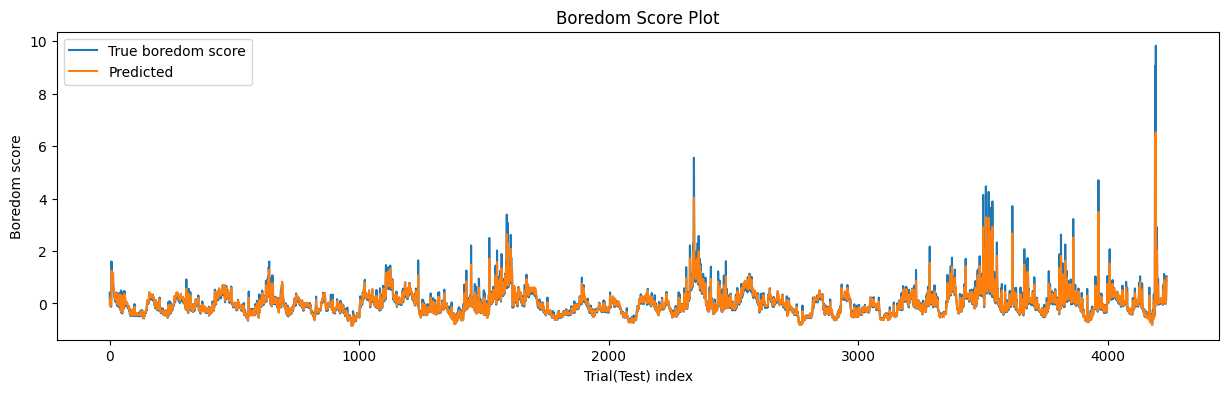

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(y_test.values, label='True boredom score')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Trial(Test) index')
plt.ylabel('Boredom score')
plt.title('Boredom Score Plot')
plt.show()

# Conclusion/Report

**Model:
Random Forest Regression**, consists of 50 independent decision trees giving their boredom score output and the overall avg. of them is what we get as y_pred. It is used here at it can capture multiple feautres and works well on non-linear data. Moreover I had covered this concept recently in my BCS project

The **MAE**, which is simply the mod delta of the prediction and actual value is 0.06 which is well within a good range for predictiction. And the plot also is indicating that the general trends have been captured well by the model except extremely high spikes of boredom

A simple observation can be made, is that, **the mouse undergoes cyclic behaviour i.e. it is very active for sometime (<0 boredom score) and then gets progressively non-responsive/bore (>0 boredom score**

**Boredom Score:**
My boredom score is a arbitrarily weighted sum of 3 different features: Reaction time, Delay b/w trials and performance drop ~ actually the normalized values of these so that no single feature gets an advantage due to higher magnitude otherwise

**Boredome score = 0.3* (Reaction_time) + 0.1* (Delay) + 0.3* (Performance_drop)**

The weights were finalised after manually experimenting and seeing when the lowest value of MAE occurs

A positive score suggests that the mouse is getting non-responsive/bored while a negative score suggests that the mouse is active/responsive while a 0 score suggests neutral/normal behaviour